In [29]:
import os
from glob import glob
import shutil


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split

### All in together

In [30]:
# Generating csv file to gather data of images 

def generate_csv(root, img_ext = ['jpg', 'png', 'jpeg']):

    # create a dataframe to store the data we get from the file
    df = pd.DataFrame(columns = ['path', 'labels'])

    # os.listdir gives the folder name of the files
    for index, label in enumerate(os.listdir(root)):

            links = glob(f"{root}/{label}/*{img_ext}")           # glob used to get all information
            #print(len(links))

            # np.ones gives 1 to total number of links and multiply with index which starts from 0
            # np.ones(4)*3 = array([3, 3, 3, 3])
            # so by this we get both path for images and the labels in numbers till(0 - 120)
            temp_df = pd.DataFrame({'path': links, 'labels': np.ones(len(links))*index})

            df = pd.concat([df, temp_df], axis = 0)      # merge all in one
        
    return df

In [31]:
data = generate_csv('C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train')
data

,path,labels
0,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
1,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
2,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
3,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
4,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
...,...,...
223,C:\Users\ritth\code\Data\archive\asl_alphabet_...,2.0
224,C:\Users\ritth\code\Data\archive\asl_alphabet_...,2.0
225,C:\Users\ritth\code\Data\archive\asl_alphabet_...,2.0
226,C:\Users\ritth\code\Data\archive\asl_alphabet_...,2.0


### Split the dataset

In [32]:
train_ds, test_ds = train_test_split(data, test_size = 0.2, random_state = 0, stratify = data["labels"])
train_ds, test_ds = train_ds.reset_index(drop=True), test_ds.reset_index(drop=True)
train_ds.shape, test_ds.shape

((642, 2), (161, 2))

In [33]:
test_ds.head()

,path,labels
0,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
1,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
2,C:\Users\ritth\code\Data\archive\asl_alphabet_...,1.0
3,C:\Users\ritth\code\Data\archive\asl_alphabet_...,0.0
4,C:\Users\ritth\code\Data\archive\asl_alphabet_...,1.0


In [34]:
data["path"].values

array(['C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A10.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1000.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1001.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1002.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1003.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1004.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1005.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1006.jpg',
       'C:\\Users\\ritth\\code\\Data\\archive\\asl_alphabet_train\\asl_alphabet_train/A\\A1007.j

### Create a new folder

In [35]:
dest_folder_train = "C:\\Users\\ritth\\code\\Data\\archive\\train_data"
dest_folder_test = "C:\\Users\\ritth\\code\\Data\\archive\\test_data"

In [36]:
def copy_files(dest_folder, data):

    for pth in data.values[:, 0]:            # take the path to convert into images

        # 'C:\\Users\\ritth\\code\\Data\\datasciencebowl\\train\\train/siphonophore_physonect\\14249.jpg'
        # pth.split('/')[-1] = 'siphonophore_physonect\\14249.jpg'
        # ['siphonophore_physonect', '14249.jpg']
        folder_img = pth.split("/")[-1].split("\\")     
        folder, img = folder_img[0], folder_img[1]


        # folder join with the path Eg:[C:\Users\ritth\code\Data\datasciencebowl\train_new\trichodesmium_tuft]
        label_folder = os.path.join(dest_folder, folder)

        if not os.path.isdir(label_folder):                # if the folder does not exist 
            os.mkdir(label_folder)                         # creating the folder 
        shutil.copy(pth , label_folder)                    # copy the content of source(images) to destination(folder)

In [37]:
copy_files(dest_folder_train, train_ds)
copy_files(dest_folder_test, test_ds)

### Preprocessing

In [38]:
train_transform = transforms.Compose([
                                    transforms.Resize((224, 224)),           # resize will resize all the images into same scale(same pixels) given images size are small and big, so we take approximitily 50
                                    transforms.RandomRotation(20),
                                    transforms.RandomResizedCrop(200),      # crop adjust the images to other images in features and we taken it as 28 smaller than resize
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],        # normalize have mean and standard deviation for color pic (red, green, blue)
                                        std=[0.229, 0.224, 0.225]) 
                                    ])
    
    
test_transform = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.CenterCrop(200),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
                                   ])

### Load the data

In [39]:
# Load the training data
trainset = datasets.ImageFolder(dest_folder_train, transform = train_transform)
trainloader = DataLoader(trainset, batch_size = 64, shuffle = True)


# Load the test data
testset = datasets.ImageFolder(dest_folder_test,transform = test_transform)
testloader = DataLoader(testset, batch_size = 64, shuffle = False)

In [40]:
images, labels = iter(trainloader).next()
print(f'image size: {images[0].shape}')
trainset.classes

image size: torch.Size([3, 200, 200])


['A', 'B', 'C']

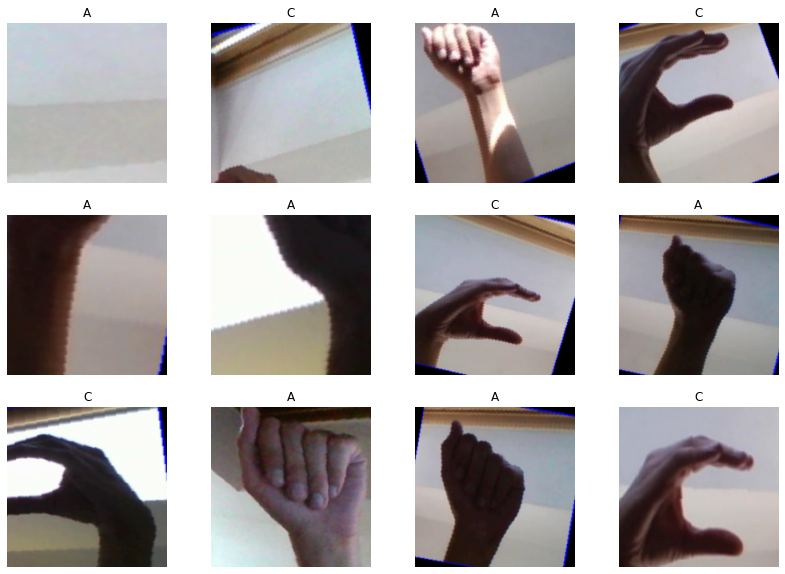

In [41]:
inv_normalize =  transforms.Normalize(
    mean=-1*np.divide([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    std=1/np.array([0.229, 0.224, 0.225])
)

def class_plot(data , classes ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        idx = np.random.randint(len(data))
        image,label = data[idx]
        label = int(label)
        l = classes[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(trainset,trainset.classes,inv_normalize)

### Model

In [43]:
model = models.resnext50_32x4d(pretrained = True)

inputs = model.fc.in_features
outputs = len(trainset.classes)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

clf = nn.Sequential( 
              nn.Linear(inputs, outputs)
                  )

model.fc = clf

c:\Users\ritth\anaconda3\envs\deep\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\ritth\anaconda3\envs\deep\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training and Validation

In [50]:
learning_rate = 0.003
epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.30

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    running_accuracy = 0
    running_loss = 0

    # training
    for x_train_batch, y_train_batch in trainloader:

        optimizer.zero_grad()

        # forward pass
        logits = model.forward(x_train_batch)
        train_preds = torch.argmax(logits.detach(), dim=1)

        # loss
        train_loss = criterion(logits, y_train_batch)
        running_loss += train_loss.item()

        # train accuracy
        train_acc = (y_train_batch == train_preds).sum() / len(y_train_batch)
        running_accuracy += train_acc.item()

        # backward pass
        train_loss.backward()
        
        # update parameters
        optimizer.step()

    # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss / len(trainloader))

     # mean accuracies
    train_accuracies.append(running_accuracy / len(trainloader))
    
    # print
    print(f'Train loss: {train_losses[-1] :.4f}')

    # validation
    model.eval()
    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0

        for x_test_batch, y_test_batch in testloader:
            
            # logits
            test_logits = model(x_test_batch)

            # predictions
            test_preds = torch.argmax(test_logits, dim=1)
            
            # accuracy
            test_acc = (y_test_batch == test_preds).sum() / len(y_test_batch)
            running_accuracy += test_acc.item()
            
            # loss
            test_loss = criterion(test_logits, y_test_batch)
            running_loss += test_loss.item()

        # mean accuracy for each epoch
        test_accuracies.append(running_accuracy / len(testloader))

        # mean loss for each epoch
        test_losses.append(running_accuracy / len(testloader))

        # print
        print(f'Test accuracy: {test_accuracies[-1]*100 :.2f}%')
        print('='*100)

        # saving best model
        # is current mean score (mean per epoch) greater than or equal to the benchmark?
        if test_accuracies[-1] > benchmark_accuracy:

            # save model 
            torch.save(model.state_dict(), './model.pth')

            # update benckmark
            benchmark_accuracy = test_accuracies[-1]

    model.train()


# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.axhline(benchmark_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({benchmark_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./learning_curve.png', dpi = 200)

plt.show()
            
    

Epoch 1/5
